In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import random
import copy

import sys
sys.path.append("Fall 2024")

import kmax as kx
import utility as util
from hierarchy import *
import z_solver as zs

In [2]:
def singular_ER_sample(n, lam):
    sum = 0
    G = nx.erdos_renyi_graph(n, lam / n)
    for u,v in G.edges():
        G[u][v]['weight'] = np.random.uniform(0,1)
    ccs = [G.subgraph(c).copy() for c in nx.connected_components(G)]

    for cc in ccs:
        if cc.number_of_nodes() != 1:
            _, _, mdvp_val, _, _ = util.path_cover(cc, root = next(iter(cc)))
            sum += mdvp_val
    
    return sum / n

def singular_GW_sample(lam):
    offspring_dist = lambda: np.random.poisson(lam)
    edge_dist = lambda: np.random.uniform(0,1)
    tree = nx.Graph(GWBP(dist=offspring_dist, MAXLEVEL=10))
    for u,v in tree.edges():
        tree[u][v]['weight'] = edge_dist()
    
    _, _, mdvp_val, _, _ = util.path_cover(tree, 0)
    # print(mdvp_val)
    return mdvp_val / tree.number_of_nodes()

In [36]:
def multiple_ER_samples(num_samples, graph_size, lam):
    # print('ER', lam)
    ratio_data = []
    for _ in range(num_samples):
        ratio_data.append(singular_ER_sample(graph_size, lam))
    return ratio_data

def multiple_GW_samples(num_samples, lam):
    # print('GW', lam)
    ratio_data = []
    for _ in range(num_samples):
        ratio_data.append(singular_GW_sample(lam))
    return ratio_data

def h(x):
    return (2 + x) * np.exp(-x)

def get_fbars(num_samples, sens = 2):
    fbar_zero = {}
    for lam in [round(i * (10 ** -sens), sens) for i in range(1, 10 ** sens)]:
        _, _, temp_fbars = zs.compute_z_pdf(lam, num_samples)
        fbar_zero[lam] = temp_fbars[0]
    return fbar_zero

def numerical_integral(lambdas, num_samples, sens = 2):
    fbar_zero = get_fbars(num_samples, sens)
    values = []
    for l in lambdas:
        temp_sum = 0
        for i in [round(i * (10 ** -sens), sens) for i in range(1, 10 ** sens)]:
            if i <= l:
                fbar_zero_lam = fbar_zero[i]
                dx = 10 ** -sens
                temp_sum += h(i * fbar_zero_lam) * dx
        values.append(temp_sum)
    
    return values


In [37]:
lambdas = [round(i * 0.1, 1) for i in range(1, 10)]
numerical_integral(lambdas, 1000)

[np.float64(0.1945151104894775),
 np.float64(0.3791545760354129),
 np.float64(0.554168699412152),
 np.float64(0.7199154290125724),
 np.float64(0.8768203407422872),
 np.float64(1.0253446169765064),
 np.float64(1.1659614042352624),
 np.float64(1.2991394865843282),
 np.float64(1.4253327215234506)]

In [38]:
def plot_helper(ER_data, GW_data, theoretical, lambdas):
    plt.plot(lambdas, ER_data, label='ER Ratios', marker='o')
    plt.plot(lambdas, GW_data, label='GW Ratios', marker='s')
    plt.plot(lambdas, theoretical, label = 'theroetical', marker = '*')
    plt.legend()
    plt.xlabel('lambda')
    plt.ylabel('ratio')

def ER_GW_plot(num_samples, ER_size):
    lambdas = [round(i * 0.1, 1) for i in range(1, 10)]
    ER_data = [np.mean(multiple_ER_samples(num_samples, ER_size, l)) for l in lambdas]
    GW_data = [np.mean(multiple_GW_samples(num_samples, l)) for l in lambdas]
    l_t = zip(lambdas, numerical_integral(lambdas, num_samples))
    theoretical = [1 - 1 / (2 * l) * t for l,t in l_t]
    plot_helper(ER_data, GW_data, theoretical, lambdas)

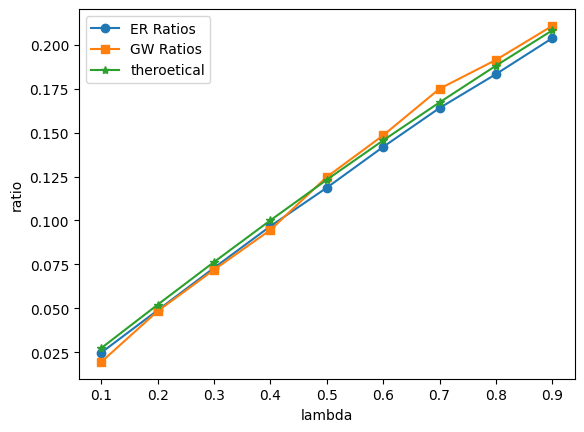

In [41]:
ER_GW_plot(1000, 100)